## Merger M20 Gini Calculations

A notebook to double check that the M20 and Gini pipelines I have previously made will work for the merger sample, i.e. where there are two galaxies involved.

### Imports

In [1]:
import glob
import os
from tqdm import tqdm
tqdm.pandas()

from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.nddata import Cutout2D
import astropy.units as u

from photutils import morphology

from shapely.geometry import Polygon, Point
from shapely.ops import unary_union
import cv2 as cv


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import dask.dataframe as dd
from dask.diagnostics import ProgressBar

In [2]:
im_folder = 'E:/GZ-DESI/images'
data_folder = 'E:/GZ-DESI/data'

In [3]:
merger_dist_ims = glob.glob(f'{im_folder}/mergers/*.fits')

In [4]:
df_paths = pd.DataFrame(merger_dist_ims).rename(columns = {0 : 'im_paths'})

In [5]:
df_paths.im_paths.iloc[0]

'E:/GZ-DESI/images/mergers\\100000_1509-cutout.fits'

In [6]:
df_ids = (
    df_paths[:50]
    .assign(id_str = df_paths[:50].im_paths.apply(lambda x: os.path.basename(x).replace('-cutout.fits','').replace('gray-','')))
)


### Testing Getting GINI Coefficient

In [7]:
n = 19

In [8]:
data = fits.getdata(df_paths.im_paths.iloc[n])
header = fits.getheader(df_paths.im_paths.iloc[n])

In [9]:
header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    3 / number of data axes                            
NAXIS1  =                  256 / length of data axis 1                          
NAXIS2  =                  256 / length of data axis 2                          
NAXIS3  =                    4 / length of data axis 3                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
SURVEY  = 'LegacySurvey'                                                        
VERSION = 'DR10    '                                                            
IMAGETYP= 'image   '                                                            
BANDS   = 'griz    '        

C:\Users\oryan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


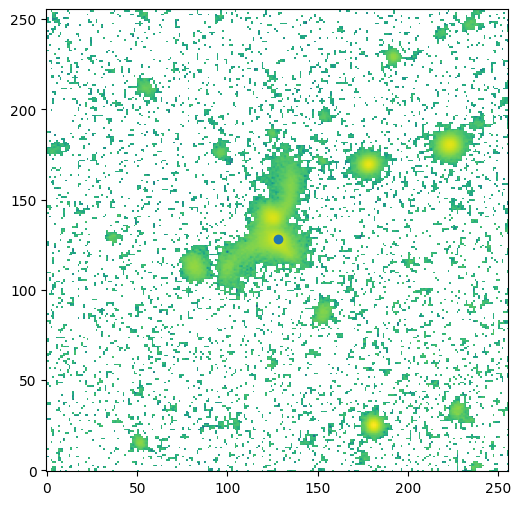

In [10]:
plt.figure(figsize = (6,6))
plt.imshow(np.log10(data[1,:,:]), origin = 'lower')
plt.scatter(data.shape[1]/2, data.shape[2]/2)
plt.show()

Ok, so, issue is that the galaxy is not the center of attention! Need to zoom in on the galaxy.

In [11]:
df = pd.read_parquet(f'{data_folder}/2023-03-15-cats/definitive-merged-interesting-params.parquet', engine = 'pyarrow').query('category == "merger"')

In [12]:
df_ids.id_str.iloc[0]

'100000_1509'

In [13]:
row = df.query('id_str == @df_ids.id_str.iloc[1]')

In [14]:
row

,id_str,merging_none_fraction,merging_minor-disturbance_fraction,merging_major-disturbance_fraction,merging_merger_fraction,category,ra,dec,log_l_ha,log_l_oiii,photo_z,spec_z,redshift,redshift_nsa,total_sfr_avg,elpetro_mass,logMH,elpetro_mass_log,log_m_bh,log_bolometric_l
76560,100000_2668,0.097775,0.076922,0.222822,0.602481,merger,32.33444,-44.223671,NaN,NaN,0.02938,NaN,0.02938,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Getting the Petrosian Radius

In [15]:
df_all_data = pd.read_parquet(f'{data_folder}/2023-03-15-cats/int-predicted-catmerged.parquet', engine = 'pyarrow')

In [16]:
df_red = df_all_data[['id_str','ra','dec','petro_theta','est_petro_th50', 'petro_th50', 'petro_th90']]

In [17]:
df_merged = df_ids.merge(df_red, on = 'id_str', how = 'left')

### Creating a Pipeline

In [18]:
df_merged.head()

,im_paths,id_str,ra,dec,petro_theta,est_petro_th50,petro_th50,petro_th90
0,E:/GZ-DESI/images/mergers\100000_1509-cutout.fits,100000_1509,32.045648,-44.287172,NaN,1.882589,NaN,NaN
1,E:/GZ-DESI/images/mergers\100000_2668-cutout.fits,100000_2668,32.334440,-44.223671,NaN,2.469401,NaN,NaN
2,E:/GZ-DESI/images/mergers\100002_2530-cutout.fits,100002_2530,32.771774,-44.220135,NaN,1.553682,NaN,NaN
3,E:/GZ-DESI/images/mergers\100002_3174-cutout.fits,100002_3174,32.923122,-44.176018,NaN,2.123728,NaN,NaN
4,E:/GZ-DESI/images/mergers\100003_1367-cutout.fits,100003_1367,33.363270,-44.293863,NaN,2.983752,NaN,NaN


In [19]:
del df_all_data, df_red

In [21]:
petro_50 = df_merged.est_petro_th50.iloc[n]
path = df_merged.im_paths.iloc[n]
ra = df_merged.ra.iloc[n]
dec = df_merged.dec.iloc[n]

In [22]:
WCS(header, naxis=2)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 37.1450649428028  -44.3071102206979  
CRPIX : 128.5  128.5  
CD1_1 CD1_2  : -7.27777777777778e-05  0.0  
CD2_1 CD2_2  : 0.0  7.27777777777778e-05  
NAXIS : 256  256  4

In [23]:
data = fits.getdata(path)
header = fits.getheader(path)

w = WCS(header, naxis = 2)

size = u.Quantity((10*petro_50, 10*petro_50), u.arcsec)
coord = SkyCoord(ra = ra * u.deg, dec = dec * u.deg, frame = 'icrs')
cutout = Cutout2D(data[1,:,:], coord, size, wcs = w)

naive_gini = morphology.gini(cutout.data)
naive_gini

0.8093754369774352

### Applying Contours

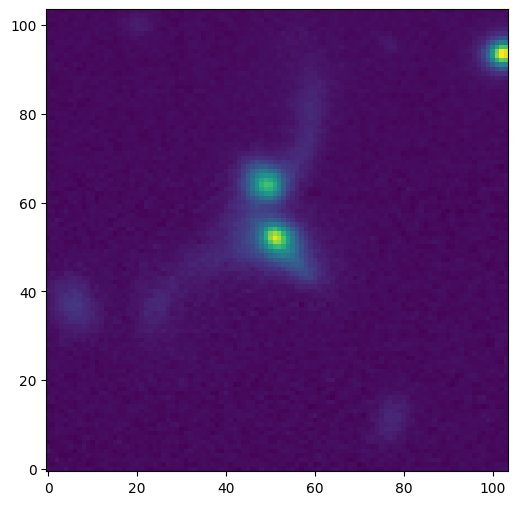

In [24]:
plt.figure(figsize = (6,6))
plt.imshow(cutout.data, origin = 'lower')
plt.show()

In [25]:
cutout.data

array([[ 0.00164081,  0.00094436,  0.00170762, ...,  0.00105308,
         0.00526442,  0.00871507],
       [-0.00127265, -0.00491668, -0.00124494, ...,  0.00399815,
         0.00275621,  0.00292555],
       [-0.00583427, -0.00099463,  0.01265732, ..., -0.00477696,
        -0.00566321, -0.00607194],
       ...,
       [ 0.00305039,  0.00262945, -0.00063403, ...,  0.0074019 ,
         0.00972266,  0.00582771],
       [-0.00223985, -0.00307988, -0.00195024, ...,  0.00511127,
         0.00844054,  0.00265477],
       [-0.00126205,  0.00276829, -0.00152358, ..., -0.00113255,
         0.00223211,  0.00679198]], dtype=float32)

In [28]:
cutout_int = cutout.data.copy()
cut = np.percentile(cutout.data,90)
cutout_int[cutout_int <= cut] = 0
cutout_int[cutout_int > cut] = 1
cutout_int = cutout_int.astype(int)

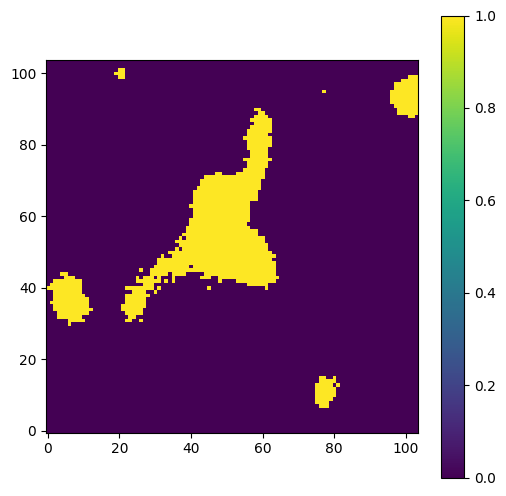

In [29]:
plt.figure(figsize = (6,6))
plt.imshow(cutout_int, origin = 'lower')
plt.colorbar()
plt.show()

In [30]:
contours, _ = cv.findContours(cutout_int, cv.RETR_FLOODFILL, cv.CHAIN_APPROX_NONE)

In [31]:
def getting_correct_contours(contours):
    length = 0
        
    for i in contours:
        if len(i) > length:
            correct_contours = i
            length = len(i)
    
    return correct_contours

In [32]:
contours_nested_list = getting_correct_contours(contours)

In [33]:
def conts_to_list(contours):
    contour_list = []
    for i in range(len(contours)):
        row = contours[i][0]
        contour_list.append([row[0], row[1]])
    return contour_list

In [34]:
def calc_gini_func(pixels):
    mean_flux = np.mean(abs(pixels))
    ordered_pixels = np.sort(pixels)
    n = len(ordered_pixels)
    
    gini = (((2 * np.arange(1, n + 1)) - n) - 1)*np.abs(ordered_pixels)
        
    normalization =  (mean_flux * n * (n - 1))
    
    return np.sum(gini) / normalization

In [35]:
extracted_contour_list = conts_to_list(contours_nested_list)

In [36]:
contour_arr = np.zeros([len(extracted_contour_list),2])
for i in range(len(extracted_contour_list)):
    contour_arr[i,0] = extracted_contour_list[i][0]
    contour_arr[i,1] = extracted_contour_list[i][1]

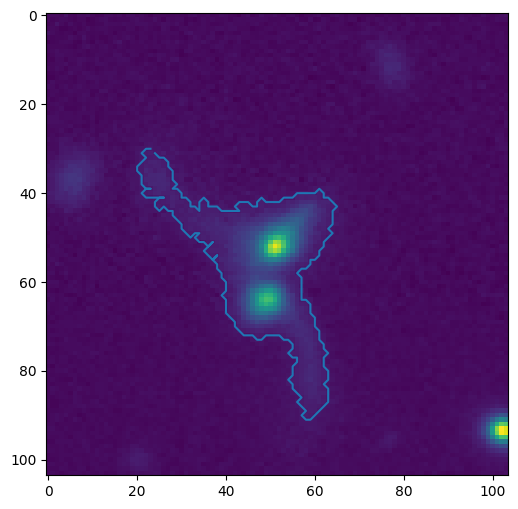

In [37]:
plt.figure(figsize = (6,6))
plt.imshow(cutout.data)
plt.plot(contour_arr[:,0], contour_arr[:,1])
plt.show()

In [38]:
pl = Polygon(contour_arr)

In [39]:
pixels_mask = np.zeros(cutout.data.shape).astype(bool)
for i in range(cutout.data.shape[0]):
    for j in range(cutout.data.shape[1]):
        pt = Point(i,j)
        if pl.contains(pt):
            pixels_mask[i,j] = True
pixels_mask = pixels_mask.T

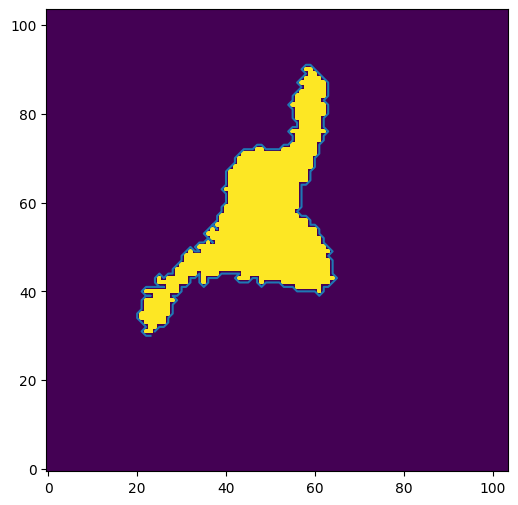

In [40]:
test_im = np.zeros(cutout.data.shape)
test_im[pixels_mask] = 1
plt.figure(figsize = (6,6))
plt.imshow(test_im, origin = 'lower')
plt.plot(contour_arr[:,0], contour_arr[:,1])
plt.show()

In [41]:
reduced_cutout = cutout.data[pixels_mask]

In [42]:
homemade_gini = calc_gini_func(reduced_cutout)
homemade_gini

0.43940016660914005

In [43]:
official_gini = morphology.gini(reduced_cutout)
official_gini

0.43940016660914005

### Using a Pipeline

In [164]:
def getting_correct_contours(contours):
    length = 0
        
    for i in contours:
        if len(i) > length:
            correct_contours = i
            length = len(i)
    
    return correct_contours

In [165]:
def conts_to_list(contours):
    contour_list = []
    for i in range(len(contours)):
        row = contours[i][0]
        contour_list.append([row[0], row[1]])
    return contour_list

In [166]:
def get_galaxy(cutout):
    cutout_int = cutout.data.copy()
    
    cut = np.percentile(cutout.data,65)
    cutout_int[cutout_int <= cut] = 0
    cutout_int[cutout_int > cut] = 1
    cutout_int = cutout_int.astype(int)
    
    contours, _ = cv.findContours(cutout_int, cv.RETR_FLOODFILL, cv.CHAIN_APPROX_NONE)
    
    contours_nested_list = getting_correct_contours(contours)
    
    extracted_contour_list = conts_to_list(contours_nested_list)
    
    contour_arr = np.zeros([len(extracted_contour_list),2])
    for i in range(len(extracted_contour_list)):
        contour_arr[i,0] = extracted_contour_list[i][0]
        contour_arr[i,1] = extracted_contour_list[i][1]
        
    pl = Polygon(contour_arr)
    
    pixels_mask = np.zeros(cutout.data.shape).astype(bool)
    for i in range(cutout.data.shape[0]):
        for j in range(cutout.data.shape[1]):
            pt = Point(i,j)
            if pl.contains(pt):
                pixels_mask[i,j] = True
    pixels_mask = pixels_mask.T
    
    reduced_cutout = cutout.data[pixels_mask]
    
    return reduced_cutout

In [167]:
def calc_gini_r(path, petro_50, ra, dec):
    
    if np.isnan(petro_50):
        return 'Failed'
    
    data = fits.getdata(path)
    header = fits.getheader(path)
    
    w = WCS(header, naxis = 2)
    
    size = u.Quantity((4*petro_50, 4*petro_50), u.arcsec)
    coord = SkyCoord(ra = ra * u.deg, dec = dec * u.deg, frame = 'icrs')
    try:
        cutout = Cutout2D(data[1,:,:], coord, size, wcs = w, mode='strict')
    except:
        return 'partial-overlap'
    
    if np.sum(cutout.data) == 0:
        return 'empty-image'
    
    reduced_cutout = get_galaxy(cutout)
    
    gini = morphology.gini(reduced_cutout)
    
    return gini

In [168]:
df_ginis = (
    df_merged
    .assign(gini = df_merged.progress_apply(lambda row: calc_gini_r(row.im_paths, row.est_petro_th50, row.ra, row.dec), axis = 1))
)

100%|██████████| 10/10 [00:00<00:00, 23.51it/s]
